# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

-

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 500 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
%load_ext autoreload
%autoreload 1
%aimport shared_functions
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
from functools import reduce
import sklearn
import shared_functions

## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
G = shared_functions.read_G(edges_csv_file, max_edges)

Using 500 edges out of 229338 available (0.22% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [4]:
centrality_measures = shared_functions.centrality_measures(G)
print centrality_measures.keys()

['eigenvector_centrality', 'degree', 'betweenness_centrality']


#### Has link with node 1?

In [5]:
centrality_measures['has_link_to_node_1'] = shared_functions.has_link_to_node(G, 1)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [6]:
df = pd.read_csv(nodes_csv_file)

In [7]:
df = shared_functions.add_sha256_column_from_id(df)
df = shared_functions.merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [8]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory'
]

numeric_features = [
    'degree',
    'eigenvector_centrality',
    #'closeness_centrality',
    'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = shared_functions.prepare_data(df, numeric_features)

### Remove nodes without price and outliers

In [9]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [10]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'sha256_id', u'has_link_to_node_1',
       u'eigenvector_centrality', u'degree', u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [11]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,rating,width,height,depth,weight,sha256_id,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
count,209.000000,209,209,209,205,206,0.0,65,145,145,...,209.000000,209.000000,209.000000,209.000000,209.000000,2.090000e+02,209.000000,209.000000,209.000000,209.000000
unique,NaN,209,209,188,2,61,NaN,65,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Introduction to Differential Geometry of Space...,https://www.amazon.com.br/dp/1305272420/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,6 de outubro de 2003,Livros,Livros,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,1,5,132,46,NaN,1,145,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1358.755981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.544444,16.480350,23.370490,2.470005,508.523240,2.056343e+09,0.090909,0.042595,4.430622,0.017158
std,987.898709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.320823,2.595949,2.043063,1.148541,216.617141,1.161107e+09,0.288170,0.052606,10.942429,0.054584
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,10.000000,17.000000,0.500000,40.800000,1.612626e+07,0.000000,0.000798,1.000000,0.000000
25%,300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.544444,14.000000,21.600000,1.500000,358.000000,1.088718e+09,0.000000,0.012119,1.000000,0.000000
50%,1756.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.544444,16.000000,23.400000,2.400000,513.595238,1.993779e+09,0.000000,0.025794,2.000000,0.003454
75%,1993.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.544444,18.300000,24.600000,3.200000,635.000000,2.930320e+09,0.000000,0.056808,3.000000,0.009988


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [12]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,rating,width,height,depth,weight,sha256_id,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,...,4.000000,14.0,21.0,0.6,181.0,3564330554,0,0.087357,19,0.088134
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,...,4.600000,14.6,21.0,1.9,363.0,1309098117,1,0.308116,62,0.263555
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.544444,14.4,20.8,0.8,200.0,1260550007,1,0.258043,54,0.296973
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.500000,13.7,21.5,1.6,381.0,4012708477,1,0.116720,18,0.114848
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.500000,13.8,21.8,4.0,939.0,3891707921,0,0.401867,86,0.433707
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,5.000000,13.8,21.5,2.2,581.0,2030201243,0,0.175059,42,0.149620
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,...,4.544444,13.7,21.5,0.8,159.0,744636978,0,0.048330,9,0.015507
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,...,5.000000,13.8,21.6,1.0,159.0,425205287,0,0.012439,9,0.140883
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,...,4.544444,13.6,20.3,2.3,522.0,1246026773,0,0.126375,23,0.090085
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.544444,14.0,20.3,1.3,159.0,1338518310,0,0.035269,14,0.061425


## Random forest using multiple features, has_link_to_node_1 as target

### Preparing data

In [13]:
target, features, feature_list, test_features, test_target = shared_functions.prepare_datasets(df, numeric_features, categorical_features, 'has_link_to_node_1')

Numeric features:  ['degree', 'eigenvector_centrality', 'betweenness_centrality', 'ranking', 'reviewCount', 'pages', 'weight', 'height', 'width', 'depth', 'rating']
Categorical features:  ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10', 'language', 'coverType', 'publisher', 'rankingCategory']
Target column:  has_link_to_node_1
Test percentage:  0.200956937799
Train features shape:  (167, 155)
Train target shape:  (167,)
Test features shape:  (42, 155)
Test target shape:  (42,)


### Average links to node 1

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

In [14]:
average_target = np.average(target)
print "Average has_link_to_node_1: ", average_target

Average has_link_to_node_1:  0.08383233532934131


### Cross val

#### Run cross val

In [15]:
rf, scores = shared_functions.run_cross_validation_classification(features, target)

#### Cross val score

In [16]:
shared_functions.print_score_summary_classification(scores)

True

#### List of most important features

In [17]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,height,1.269887e-01
1,sha256_id,1.269135e-01
2,width,1.003730e-01
3,weight,1.002802e-01
4,category4_Física,9.827633e-02
5,pages,7.199388e-02
6,depth,4.578500e-02
7,ranking,3.910513e-02
8,publisher_Cambridge University Press,3.043524e-02
9,category5_Matemática Pura,2.690218e-02


## Test dataset and visual inspection

In [18]:
test_predictions_probability = rf.predict_proba(test_features)
test_predictions = rf.predict(test_features)

###  Previsto vs. real

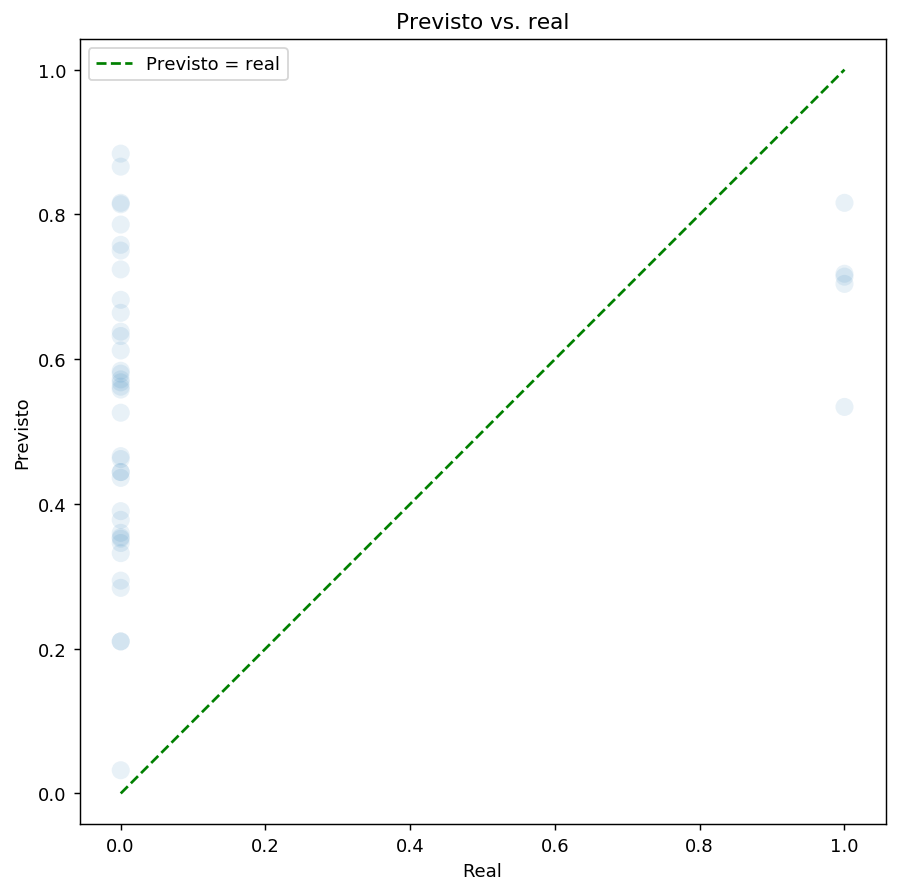

In [19]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(test_target, map(lambda i: i[1], test_predictions_probability), 100, alpha=0.1, edgecolors="none")
baseline = [0, np.max(test_target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Previsto = real")
ax = plt.gca()
ax.set_ylabel(u"Previsto")
ax.set_xlabel(u"Real")
ax.legend()
plt.title(u"Previsto vs. real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 150)
#plt.ylim(0, 150)
plt.show()

#### Confusion matrix

In [20]:
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, map(lambda p: 1 if p[1] > 0.5 else 0, test_predictions_probability))

Confusion matrix, without normalization
[[17 20]
 [ 0  5]]


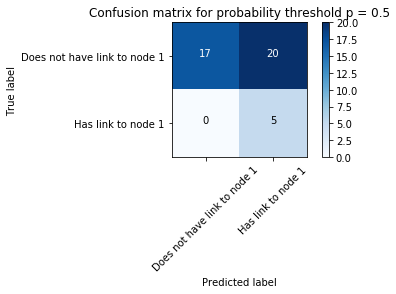

In [21]:
plt.figure()
shared_functions.plot_confusion_matrix(cnf_matrix, classes=['Does not have link to node 1', 'Has link to node 1'],
                      title='Confusion matrix for probability threshold p = 0.5')
plt.show()

#### ROC Curve

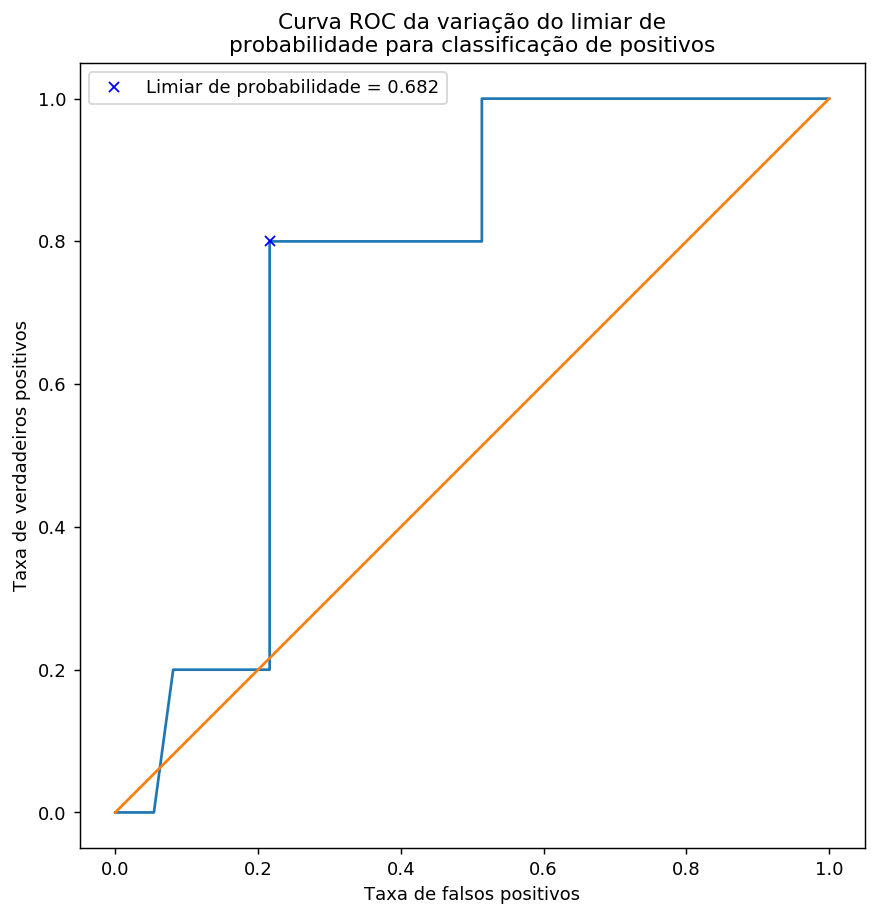

In [22]:
steps = 1001
x = []
y = []
closest_to_optimal_distance = 99999
closest_to_optimal_probability = None
closest_to_optimal_point = None
for r in range(0, steps):
    s = 1/(steps - 1) * r
    m = sklearn.metrics.confusion_matrix(test_target, map(lambda p: 1 if p[1] > s else 0, test_predictions_probability))
    tn = m[0][0]
    fp = m[0][1]
    fn = m[1][0]
    tp = m[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    y.append(tpr)
    x.append(fpr)
    distance = ((fpr - 0)**2.0 + (tpr - 1)**2.0)**0.5
    if distance < closest_to_optimal_distance:
        closest_to_optimal_point = [fpr, tpr]
        closest_to_optimal_distance = distance
        closest_to_optimal_probability = s
plt.figure(figsize=(8,8), dpi=130)
plt.plot(x, y)
plt.plot([0, 1], [0, 1])
plt.plot(closest_to_optimal_point[0], closest_to_optimal_point[1], "bx", label=u"Limiar de probabilidade = " + str(closest_to_optimal_probability))
plt.axes().set_aspect('equal')
plt.axes().set_ylabel(u"Taxa de verdadeiros positivos")
plt.axes().set_xlabel(u"Taxa de falsos positivos")
plt.axes().legend()
plt.title(u"Curva ROC da variação do limiar de\nprobabilidade para classificação de positivos")
plt.axes().set_aspect('equal')
plt.show()

Confusion matrix, without normalization
[[29  8]
 [ 1  4]]


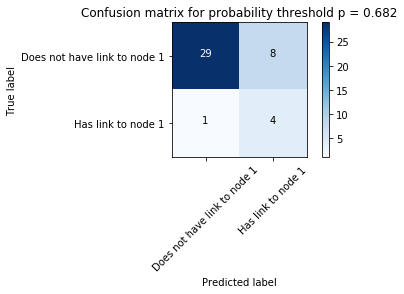

In [23]:
## Confusion matrix on probability threshold
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, map(lambda p: 1 if p[1] > closest_to_optimal_probability else 0, test_predictions_probability))
plt.figure()
shared_functions.plot_confusion_matrix(cnf_matrix, classes=['Does not have link to node 1', 'Has link to node 1'],
                      title='Confusion matrix for probability threshold p = ' + str(closest_to_optimal_probability))
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [24]:
# Calculate the absolute errors
errors = abs(test_predictions - test_target)
errors_baseline = abs(average_target - test_target)
# Print out the mean absolute error (mae)
print('Mean absolute prediction error: ', round(np.mean(errors), 2))
print('Mean absolute error using average: ',
      round(np.mean(errors_baseline), 2))

('Mean absolute prediction error: ', 0.48)
('Mean absolute error using average: ', 0.18)


### Join data

In [25]:
pd.set_option('display.max_columns', None)
predicted_df, joined_predicted_df = shared_functions.join_predicted_df(df, test_features, test_target, test_predictions, errors, 1, errors_baseline, 1)

### Worst predictions

Below we can inspect the rows with the biggest prediction error.

In [26]:
joined_predicted_df.sort_values('error', ascending = False).head(10)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.789422e+09,"[2789421822.0, 1.0, 0.0121192297181, 0.0, 2990...",1.0,0.083832,1,1,1.0,0.0,1878,The Math Book: From Pythagoras to the 57th Dim...,https://www.amazon.com.br/dp/1402788290/,Clifford A. Pickover (Autor),Capa comum,Sterling,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,NaN,NaN,NaN,NaN,NaN,NaN,1402788290,978-1402788291,Inglês,1,75.06,299040.000000,528.0,5.305556,4.544444,18.4,21.6,3.2,513.595238,0,0.012119,1,0.000000
2.358283e+09,"[2358282686.0, 6.0, 0.0934020191034, 0.0185740...",1.0,0.083832,1,1,1.0,0.0,2092,Theory and Application of Infinite Series,https://www.amazon.com.br/dp/0486661652/,"Konrad Knopp (Autor),",Capa comum,Dover Publications,NaN,1 de março de 1990,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Infinito,NaN,NaN,NaN,NaN,NaN,0486661652,978-0486661650,Inglês,1,82.75,186819.000000,563.0,5.305556,4.544444,13.7,21.5,2.9,590.000000,0,0.093402,6,0.018574
1.838639e+09,"[1838639412.0, 1.0, 0.0165629074328, 0.0, 3605...",1.0,0.083832,1,1,1.0,0.0,306,Quantum Computing: A Gentle Introduction,https://www.amazon.com.br/dp/0262526670/,"Eleanor Rieffel (Autor),",Capa comum,MIT Press,NaN,MA) (29 de agosto de 2014,Livros,Livros,Inglês e Outras Línguas,"Computação, Informática e Mídias Digitais",Hardware,Mainframes e Minicomputadores,NaN,NaN,NaN,NaN,NaN,0262526670,978-0262526678,Inglês,1,132.06,36053.000000,372.0,5.305556,4.544444,17.8,22.9,1.6,590.000000,0,0.016563,1,0.000000
7.897180e+08,"[789717993.0, 1.0, 0.0112364400044, 0.0, 15086...",1.0,0.083832,1,1,1.0,0.0,1838,Introduction to Mechanics and Symmetry: A Basi...,https://www.amazon.com.br/dp/1441931430/,"Jerrold E. Marsden (Autor),",Capa comum,Springer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1441931430,978-1441931436,Inglês,1,596.13,150863.486486,604.0,5.305556,4.544444,15.5,23.5,3.5,259.000000,0,0.011236,1,0.000000
2.900403e+09,"[2900402713.0, 4.0, 0.0696103045446, 0.0134768...",1.0,0.083832,1,1,1.0,0.0,2112,Differential Equations with Applications and H...,https://www.amazon.com.br/dp/1498702597/,George F. Simmons (Autor),Capa dura,Chapman and Hall/CRC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1498702597,978-1498702591,Inglês,1,620.77,150863.486486,764.0,5.305556,4.544444,15.9,23.5,4.4,513.595238,0,0.069610,4,0.013477
2.187268e+09,"[2187268449.0, 8.0, 0.123722306821, 0.02770929...",1.0,0.083832,1,1,1.0,0.0,1699,Introduction to Analysis,https://www.amazon.com.br/dp/0486650383/,"Maxwell Rosenlicht (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Matemática Pura,Cálculo,NaN,NaN,NaN,NaN,0486650383,978-0486650388,Inglês,1,53.32,179993.000000,272.0,5.305556,4.544444,13.5,21.6,1.3,227.000000,0,0.123722,8,0.027709
4.237676e+09,"[4237676055.0, 1.0, 0.00811159683967, 0.0, 150...",1.0,0.083832,1,1,1.0,0.0,336,A Student's Guide to Infinite Series and Seque...,https://www.amazon.com.br/dp/1107640482/,Bernhard W. Bach Jr. (Autor),Capa comum,Cambridge University Press,NaN,17 de maio de 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1107640482,978-1107640481,Inglês,1,140.21,150863.486486,198.0,5.305556,4.544444,15.2,22.8,1.1,340.000000,0,0.008112,1,0.000000
1.896117e+09,"[1896117274.0, 3.0, 0.0544765892627, 0.0134759...",1.0,0.083832,1,1,1.0,0.0,329,"Introduction to Probability, Statistics, and R...",https://www.amazon.com.br/dp/0990637204/,Hossein Pishro-Nik (Autor),Capa comum,"Kappa Research, LLC",NaN,24 de agosto de 2014,Livros,Livro

### Best predictions

In [27]:
joined_predicted_df.sort_values('error', ascending = True).head(10)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7.345288e+08,"[734528784.0, 1.0, 0.00226381633859, 0.0, 1562...",0.0,0.083832,1,1,0.0,0.0,2215,Covariant Loop Quantum Gravity: An Elementary ...,https://www.amazon.com.br/dp/1107069629/,"Carlo Rovelli (Autor),",Capa dura,Cambridge University Press,NaN,1 de dezembro de 2014,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Gravidade,NaN,NaN,NaN,NaN,NaN,1107069629,978-1107069626,Inglês,1,285.32,156217.000000,266.0,5.305556,4.544444,19.4,25.4,1.7,780.000000,0,0.002264,1,0.000000
6.403540e+08,"[640354001.0, 2.0, 0.01772638096, 0.0073838343...",0.0,0.916168,1,1,1.0,1.0,1871,In Praise of Simple Physics – The Science and ...,https://www.amazon.com.br/dp/0691178526/,Paul J. Nahin (Autor),Capa comum,Princeton University Press,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0691178526,978-0691178523,Inglês,1,54.86,167000.000000,272.0,5.305556,4.544444,15.2,22.9,1.3,431.000000,1,0.017726,2,0.007384
5.079806e+08,"[507980601.0, 1.0, 0.0257944521118, 0.0, 65399...",0.0,0.083832,1,1,0.0,0.0,249,An Introduction to Ordinary Differential Equat...,https://www.amazon.com.br/dp/0486659429/,"Joseph Landin (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486659429,978-0486659428,Inglês,1,46.60,65399.000000,292.0,1.000000,5.000000,13.8,21.7,1.5,318.000000,0,0.025794,1,0.000000
2.668889e+09,"[2668888666.0, 1.0, 0.000798420056958, 0.0, 38...",0.0,0.083832,1,1,0.0,0.0,34,Statistical Mechanics: Volume 4 of Pauli Lectu...,https://www.amazon.com.br/dp/0486414604/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486414604,978-0486414607,Inglês,1,32.32,38588.000000,144.0,5.305556,4.544444,13.7,21.6,0.8,159.000000,0,0.000798,1,0.000000
2.842536e+08,"[284253578.0, 2.0, 0.0477401167054, 0.00274510...",0.0,0.083832,1,1,0.0,0.0,1698,Abstract Algebra,https://www.amazon.com.br/dp/0471433349/,"David S. Dummit (Autor),",Capa dura,Wiley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0471433349,978-0471433347,Inglês,1,857.61,150863.486486,944.0,5.305556,4.544444,18.5,23.4,3.3,513.595238,0,0.047740,2,0.002745
1.380658e+09,"[1380658471.0, 3.0, 0.0410158103297, 0.0150178...",0.0,0.083832,1,1,0.0,0.0,338,Introduction to Electrodynamics,https://www.amazon.com.br/dp/1108420419/,David J. Griffiths (Autor),Capa dura,Cambridge University Press,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Elétrica e Eletrônica,Ótica,NaN,NaN,NaN,NaN,1108420419,978-1108420419,Inglês,1,409.57,173605.000000,620.0,5.305556,4.544444,19.5,24.1,3.1,513.595238,0,0.041016,3,0.015018
3.903632e+08,"[390363213.0, 3.0, 0.048950591942, 0.008156043...",0.0,0.083832,1,1,0.0,0.0,2091,An Introduction to the Calculus of Variations,https://www.amazon.com.br/dp/0486654990/,Charles Fox (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Matemática Pura,Cálculo,NaN,NaN,NaN,NaN,0486654990,978-0486654997,Inglês,1,47.23,160246.000000,304.0,5.305556,4.544444,14.0,20.3,1.3,322.000000,0,0.048951,3,0.008156
4.174793e+09,"[4174793265.0, 1.0, 0.0219456645936, 0.0, 1508...",0.0,0.083832,1,1,0.0,0.0,1694,A First Course in Abstract Algebra,https://www.amazon.com.br/dp/0201763907/,John B. Fraleigh (Autor),Capa dura,Pearson,NaN,NaN,NaN,NaN,NaN

In [28]:
joined_predicted_df.describe()

,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,edition,category8,category9,category10,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
count,42.000000,42.000000,42.0,42.0,42.000000,42.000000,42.000000,0.0,0.0,0.0,0.0,42.0,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.476190,0.182920,1.0,1.0,0.595238,0.119048,1473.976190,NaN,NaN,NaN,NaN,1.0,275.471429,164521.435650,413.738095,5.124339,4.554233,16.235714,22.997619,2.378571,497.403628,0.119048,0.041028,2.809524,0.007884
std,0.505487,0.272815,0.0,0.0,0.496796,0.327770,796.824107,NaN,NaN,NaN,NaN,0.0,266.959870,86213.593338,209.417666,0.827651,0.070794,2.199648,1.592741,1.109941,217.375486,0.327770,0.032527,2.233209,0.008728
min,0.000000,0.083832,1.0,1.0,0.000000,0.000000,7.000000,NaN,NaN,NaN,NaN,1.0,23.920000,36053.000000,96.000000,1.000000,4.500000,13.000000,19.600000,0.600000,136.000000,0.000000,0.000798,1.000000,0.000000
25%,0.000000,0.083832,1.0,1.0,0.000000,0.000000,677.000000,NaN,NaN,NaN,NaN,1.0,59.910000,131147.871622,272.000000,5.305556,4.544444,14.150000,21.600000,1.500000,319.000000,0.000000,0.016854,1.000000,0.000000
50%,0.000000,0.083832,1.0,1.0,1.000000,0.000000,1843.000000,NaN,NaN,NaN,NaN,1.0,141.080000,150863.486486,355.500000,5.305556,4.544444,15.650000,23.000000,2.300000,513.595238,0.000000,0.031854,2.000000,0.006406
75%,1.000000,0.083832,1.0,1.0,1.000000,0.000000,2020.750000,NaN,NaN,NaN,NaN,1.0,472.532500,183098.000000,583.250000,5.305556,4.544444,18.300000,23.975000,3.100000,590.000000,0.000000,0.058957,4.000000,0.014650
max,1.000000,0.916168,1.0,1.0,1.000000,1.000000,2215.000000,NaN,NaN,NaN,NaN,1.0,1142.710000,391634.000000,944.000000,5.305556,5.000000,21.100000,27.400000,5.100000,975.000000,1.000000,0.123722,9.000000,0.027709


### Visualize decision tree

In [29]:
shared_functions.render_image_first_decision_tree(rf, feature_list, 'tree-link.png')

Output image:  tree-link.png


<img src="files/image.png">